<font color='black'><font size="4"> Notebook I: baseline pour la prédiction scoring bancaire -- Le plan de ce notebook (Projet 7) est le suivant:</font></font>
<font color='black'><font size="3">
* Import les librairies
* DataFrame "train/test"
    * Analyse exploratoire du dataframe
    * Corrélation -- filter les variables du dataframe
    * Nettoyer le dataframe
    * Les variables catégorielles
    * Classification
    * Les scores metrics du baseline
    
    
* DataFrame "bureau/bureau_balance"
    * Compter les prets précédentes (dataframe: bureau)
    * Les stats des prets précédentes (dataframe: bureau)
    * Les stats des prets précédentes (dataframe: bureau_balance)
    * Compter les prets précédentes (dataframe: bureau_balance)
    * Merge les nouveau dataframes avec data_test
</font></font>  

## A) Import les librairies

In [1]:
## basic libraries
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pylab as pl

## classification & processessing libraries
from sklearn import preprocessing
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


## format image & text
pl.rcParams.update({'font.size':14})
palette = sn.color_palette("hls", 8)

## B) DataFrame "train/test"

In [3]:
data_train = pd.read_csv("application_train.csv")
data_test = pd.read_csv("application_test.csv")
data_card_description = pd.read_csv("HomeCredit_columns_description.csv")

In [4]:
### pour visualiser tout les text 
pd.options.display.max_colwidth = 200

In [5]:
## columns qui n'existe pas en data_test
[i for i in data_train.keys().tolist() if not i in data_test.keys().tolist()]

['TARGET']

### B-1) Analyse exploratoire du dataframe

<font color='darkblue'><font size="3">
Cette partie est réservée à l'analyse exploratoire du dataframe data_train 
</font></font>

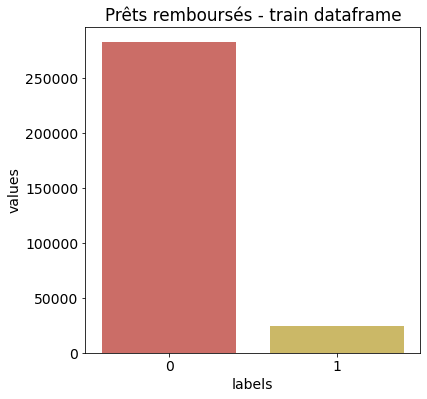

In [7]:
temp = data_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
pl.figure(figsize = (6,6))
pl.title('Prêts remboursés - train dataframe')
sn.set_color_codes("pastel")
sn.barplot(x = 'labels', y="values", data=df, palette=palette)
#locs, labels = pl.xticks()
pl.show()

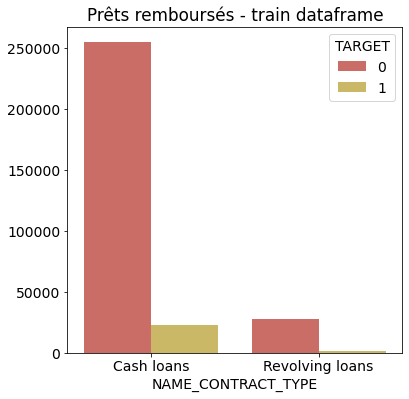

In [8]:
result = data_train.groupby(['NAME_CONTRACT_TYPE','TARGET']).size()
pl.figure(figsize=(6,6))
sn.barplot(x = result.index.get_level_values(0), y = result.values, hue = result.index.get_level_values(1), palette=palette)
pl.title('Prêts remboursés - train dataframe')
pl.show()

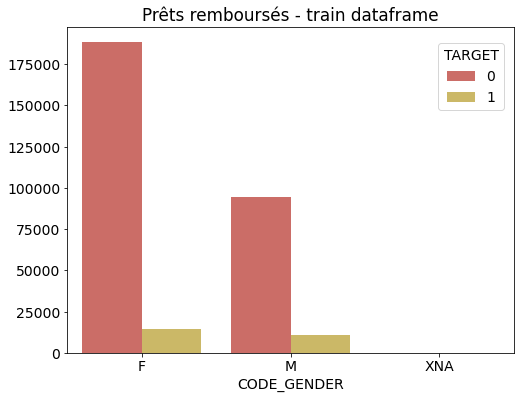

In [9]:
result = data_train.groupby(['CODE_GENDER','TARGET']).size()
pl.figure(figsize=(8,6))
sn.barplot(x = result.index.get_level_values(0), y = result.values, hue = result.index.get_level_values(1), palette=palette)
pl.legend(bbox_to_anchor=(0.83, 0.95), loc='upper left', borderaxespad=0, title='TARGET')
pl.title('Prêts remboursés - train dataframe')
pl.show()

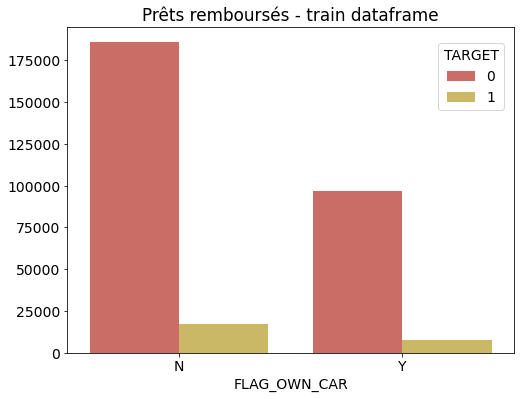

In [10]:
result = data_train.groupby(['FLAG_OWN_CAR','TARGET']).size()
pl.figure(figsize=(8,6))
sn.barplot(x = result.index.get_level_values(0), y = result.values, hue = result.index.get_level_values(1), palette=palette)
pl.legend(bbox_to_anchor=(0.83, 0.95), loc='upper left', borderaxespad=0, title='TARGET')
pl.title('Prêts remboursés - train dataframe')
pl.show()


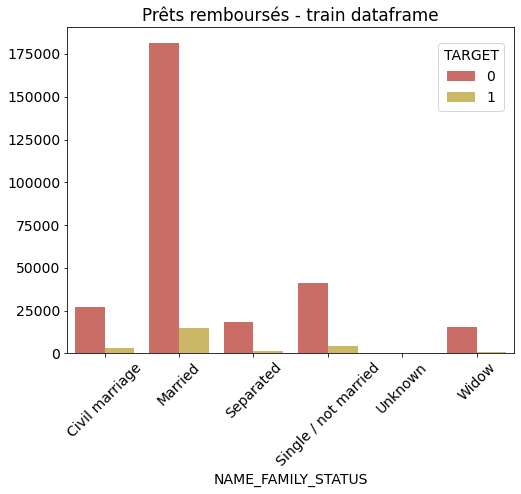

In [11]:
result = data_train.groupby(['NAME_FAMILY_STATUS','TARGET']).size()
pl.figure(figsize=(8,6))
sn.barplot(x = result.index.get_level_values(0), y = result.values, hue = result.index.get_level_values(1), palette=palette)
pl.legend(bbox_to_anchor=(0.83, 0.95), loc='upper left', borderaxespad=0, title='TARGET')
pl.xticks(rotation=45)
pl.title('Prêts remboursés - train dataframe')
pl.show()


<font color='darkblue'><font size="3"> 
Nous vérifions si certaines colonnes contiennent des valeurs aberrantes.
</font></font>

In [12]:
## colonnes du 'DAYS_BIRTHS'
(data_train['DAYS_BIRTH']/365).describe()

count    307511.000000
mean        -43.936973
std          11.956133
min         -69.120548
25%         -53.923288
50%         -43.150685
75%         -34.008219
max         -20.517808
Name: DAYS_BIRTH, dtype: float64

<font color='darkblue'><font size="3">
Les résultats sont normaux (dans l'intervalle), nous les enregistrons donc dans une nouvelle colonne nommée ''Age'' qui se réfère à l'âge des clients.    
</font></font>

In [13]:
data_train['Age']=(data_train['DAYS_BIRTH']/-365)

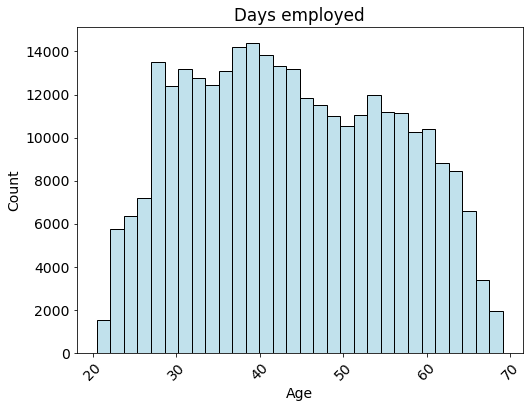

In [14]:
pl.figure(figsize=(8,6))
sn.histplot(x = 'Age', data = data_train, color = 'lightblue', bins = 30) 
pl.xticks(rotation=45)
pl.title('Days employed')
pl.show()

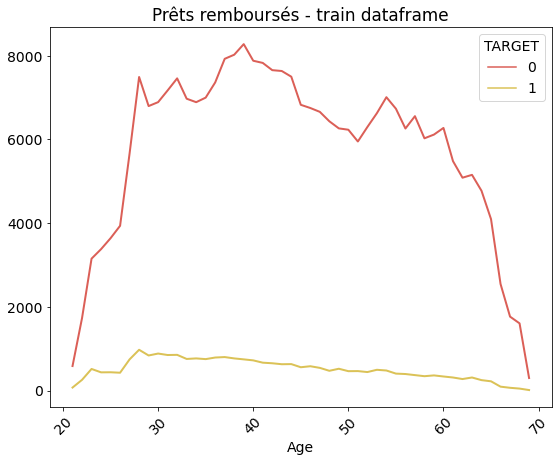

In [15]:
data_train['Age'] = np.round(data_train['Age'])
result = data_train.groupby(['Age','TARGET']).size()
pl.figure(figsize=(9,7))
sn.lineplot(x = result.index.get_level_values(0), y = result.values, hue = result.index.get_level_values(1),lw =2,palette=palette[:2])
pl.xticks(rotation=45)
pl.title('Prêts remboursés - train dataframe')
pl.show()

In [16]:
(data_train['DAYS_EMPLOYED']/365).describe()

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

<font color='darkblue'><font size="3"> 
Les valeurs indiquées ne sont pas normales, l'écart-type est supérieur au nombre moyen de jours par an.
    Nous devons détecter l'anomalie et la corriger.
</font></font>

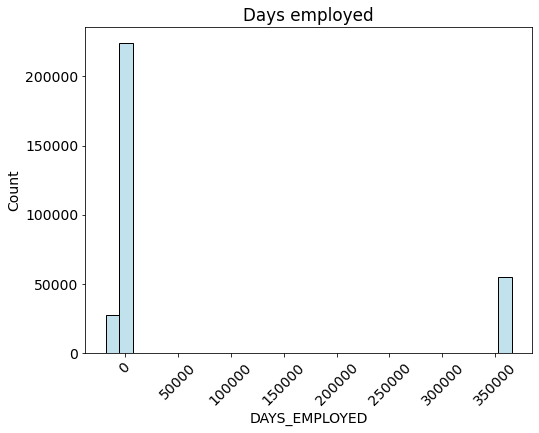

In [17]:
pl.figure(figsize=(8,6))
sn.histplot(x = 'DAYS_EMPLOYED', data = data_train, color = 'lightblue', bins = 30) 
#sns.barplot(x = result.index.get_level_values(0), y = result.values, hue = result.index.get_level_values(1), palette=palette)
pl.xticks(rotation=45)
pl.title('Days employed')
pl.show()

<font color='darkblue'><font size="3">
La valeur anormale est à 365243, nous pouvons la remplacer par la valeur max ou NaN. 

Dans ce cas, c'est mieux de la remplacer par NaN
</font></font>

In [18]:
data_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

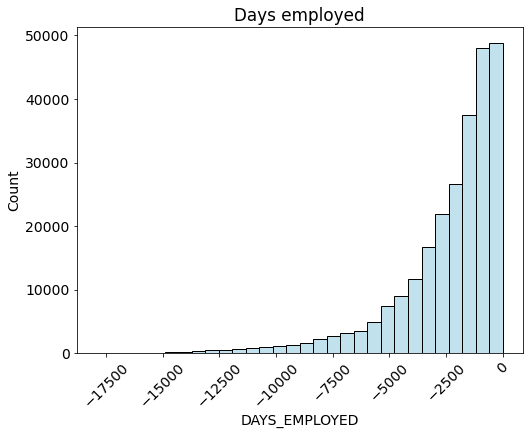

In [19]:
pl.figure(figsize=(8,6))
sn.histplot(x = 'DAYS_EMPLOYED', data = data_train, color = 'lightblue', bins = 30) 
#sns.barplot(x = result.index.get_level_values(0), y = result.values, hue = result.index.get_level_values(1), palette=palette)
pl.xticks(rotation=45)
pl.title('Days employed')
pl.show()

<font color='darkblue'><font size="3"> 
    Maintenant, nous allons examiner le % des valeurs manquantes dans chaque colonne du dataframe et les présenter dans un table par ordre croissant.
</font></font>

In [20]:
table = pd.DataFrame(data_train.isnull().sum()/(len(data_train))*100, columns=['percentage']).sort_values(by='percentage', ascending=False)
table.head(15)

,percentage
COMMONAREA_MEDI,69.872297
COMMONAREA_AVG,69.872297
COMMONAREA_MODE,69.872297
NONLIVINGAPARTMENTS_MEDI,69.432963
NONLIVINGAPARTMENTS_MODE,69.432963
NONLIVINGAPARTMENTS_AVG,69.432963
FONDKAPREMONT_MODE,68.386172
LIVINGAPARTMENTS_AVG,68.354953
LIVINGAPARTMENTS_MODE,68.354953
LIVINGAPARTMENTS_MEDI,68.354953


### B-2) Corrélation -- filtrer les variables du dataframe

<font color='darkblue'><font size="3"> 
Nous avons au total 122 colonnes, et dans ce cas, il est difficile, voire impossible, de visualiser la matrice de corrélation et de supprimer manuellement les colonnes corrélées.
    
J'ai donc dû trouver un moyen de localiser les colonnes corrélées et de réduire ainsi les dimensions de notre matrice de corrélation.    
</font></font>

In [21]:
corrMatrix = data_train.corr()

In [22]:
## Donc nous sélectionnons seulement les lignes de la matrice de corrélation où nous avons une valeur supérieure à 0.79

corr, corr2 = [],[]
for i in corrMatrix.columns:
    for j in corrMatrix.index:
        if i!=j:
            if corrMatrix[i][j]>0.79:
                corr.append([i, j])
                corr2.append(i)
                corr2.append(j)

In [23]:
## nous filtrons les colonnes corrélées pour ne pas sélectionner deux fois la même colonne

corr_axe0 = corrMatrix.filter(items=set(corr2),axis=0) 
corr_axe1 = corr_axe0.filter(items=set(corr2),axis=1) 
matrix = corrMatrix.drop(columns=set(corr2))
matrix2 = matrix.drop(index=set(corr2))

In [24]:
matrix

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
SK_ID_CURR,1.000000,-0.002108,-0.001820,-0.000433,0.000849,-0.001500,-0.000084,-0.000973,-0.000384,0.001818,...,0.000167,0.001073,0.000282,-0.002672,-0.002193,0.002099,0.000485,0.001025,0.004659,0.001483
TARGET,-0.002108,1.000000,-0.003982,-0.012817,-0.037227,0.078239,0.074958,0.041975,0.051457,0.037612,...,-0.001358,0.000215,0.003709,0.000930,0.002704,0.000788,-0.012462,-0.002022,0.019930,-0.078263
CNT_CHILDREN,-0.001129,0.019187,0.012882,0.021374,-0.025573,0.330938,0.061145,0.183395,-0.028019,0.008494,...,0.000864,0.000988,-0.002450,-0.000410,-0.000366,-0.002436,-0.010808,-0.007836,-0.041550,-0.330812
AMT_INCOME_TOTAL,-0.001820,-0.003982,1.000000,0.191657,0.074796,0.027261,-0.013005,0.027805,0.008506,-0.117273,...,0.002408,0.000242,-0.000589,0.000709,0.002944,0.002387,0.024700,0.004859,0.011690,-0.027201
AMT_CREDIT,-0.000343,-0.030369,0.156870,0.770138,0.099738,-0.055436,-0.091295,0.009621,-0.006575,-0.094191,...,0.021082,0.031023,-0.016148,-0.003906,0.004238,-0.001275,0.054451,0.015925,-0.048448,0.055482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_WEEK,0.002099,0.000788,0.002387,0.013881,-0.002149,-0.001336,0.002171,-0.001069,-0.001249,0.001661,...,-0.001275,-0.001770,0.000081,0.004706,0.217412,1.000000,-0.014096,-0.015115,0.018917,0.001252
AMT_REQ_CREDIT_BUREAU_MON,0.000485,-0.012462,0.024700,0.039148,0.078607,0.001372,-0.024433,-0.011353,-0.009660,-0.021867,...,-0.002729,0.001285,-0.003612,-0.000018,-0.005258,-0.014096,1.000000,-0.007789,-0.004975,-0.001397
AMT_REQ_CREDIT_BUREAU_QRT,0.001025,-0.002022,0.004859,0.010124,-0.001279,-0.011799,0.006567,-0.001308,-0.006200,-0.017632,...,-0.001575,-0.001010,-0.002004,-0.002716,-0.004416,-0.015115,-0.007789,1.000000,0.076208,0.011844
AMT_REQ_CREDIT_BUREAU_YEAR,0.004659,0.019930,0.011690,-0.011320,0.001003,-0.071983,-0.000527,-0.024805,-0.035099,-0.014384,...,-0.007009,-0.012126,-0.005457,-0.004597,-0.003355,0.018917,-0.004975,0.076208,1.000000,0.072011


<font color='darkblue'><font size="3"> 
Nous avons maintenant une dataframe qui contient les colonnes corrélées, mais nous devons le transformer en une matrice.
</font></font>

In [25]:
matrix = corr_axe1.unstack()
matrix_abs = matrix[(abs(matrix) >= 0.79) & (abs(matrix)<1.00)]

In [26]:
matrix_abs = pd.DataFrame(matrix_abs, columns=['value']).reset_index()

In [27]:
matrix_abs.head(15)

,level_0,level_1,value
0,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,0.950842
1,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,0.998495
2,YEARS_BUILD_AVG,YEARS_BUILD_MODE,0.989444
3,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,0.950842
4,LIVINGAREA_AVG,LIVINGAREA_MEDI,0.995596
5,LIVINGAREA_AVG,ELEVATORS_MEDI,0.865805
6,LIVINGAREA_AVG,ELEVATORS_MODE,0.852591
7,LIVINGAREA_AVG,LIVINGAREA_MODE,0.972050
8,LIVINGAREA_AVG,APARTMENTS_AVG,0.913619
9,LIVINGAREA_AVG,APARTMENTS_MEDI,0.912504


<font color='darkblue'><font size="3"> 
Pour une meilleure exploitation de cette nouvelle matrice, nous devrons regrouper pour une seule colonne, les valeurs de correlations de toutes les autres colonnes restantes.
    
Et à la fin de cette fonction, nous aurons la liste dont nous avons les colonnes corrélées.
    
**PS:** si nous avons une colonne A corrélée avec B, et colonnes B corrélé avec C, cette fonction inclura les colonnes B et C, et gardera la colonne A dans le dataframe.    
</font></font>

In [28]:
liste, correlation_liste = [],[]
for i in matrix_abs['level_0']:
    if list(matrix_abs['value'][matrix_abs['level_0']==i])!=[0.0] :
        where = matrix_abs[matrix_abs['level_0']==i].index
    
        liste.append(i)
        correlation_liste.append(matrix_abs.loc[where]['level_1'].tolist()[0])
        correlation = set(correlation_liste)
        
        ind = matrix_abs[matrix_abs["level_1"]==i].index
        matrix_abs.at[ind,'value'] = 0.0
        ind = matrix_abs[matrix_abs['level_0']==i].index
        matrix_abs.at[ind,'value'] = 0.0
        for k in correlation:
            ind = matrix_abs[matrix_abs["level_1"]==k].index
            matrix_abs.at[ind,'value'] = 0.0
            ind = matrix_abs[matrix_abs['level_0']==k].index
            matrix_abs.at[ind,'value'] = 0.0
    else:
        continue
        

In [29]:
new_data_train = data_train.drop(columns=set(liste))

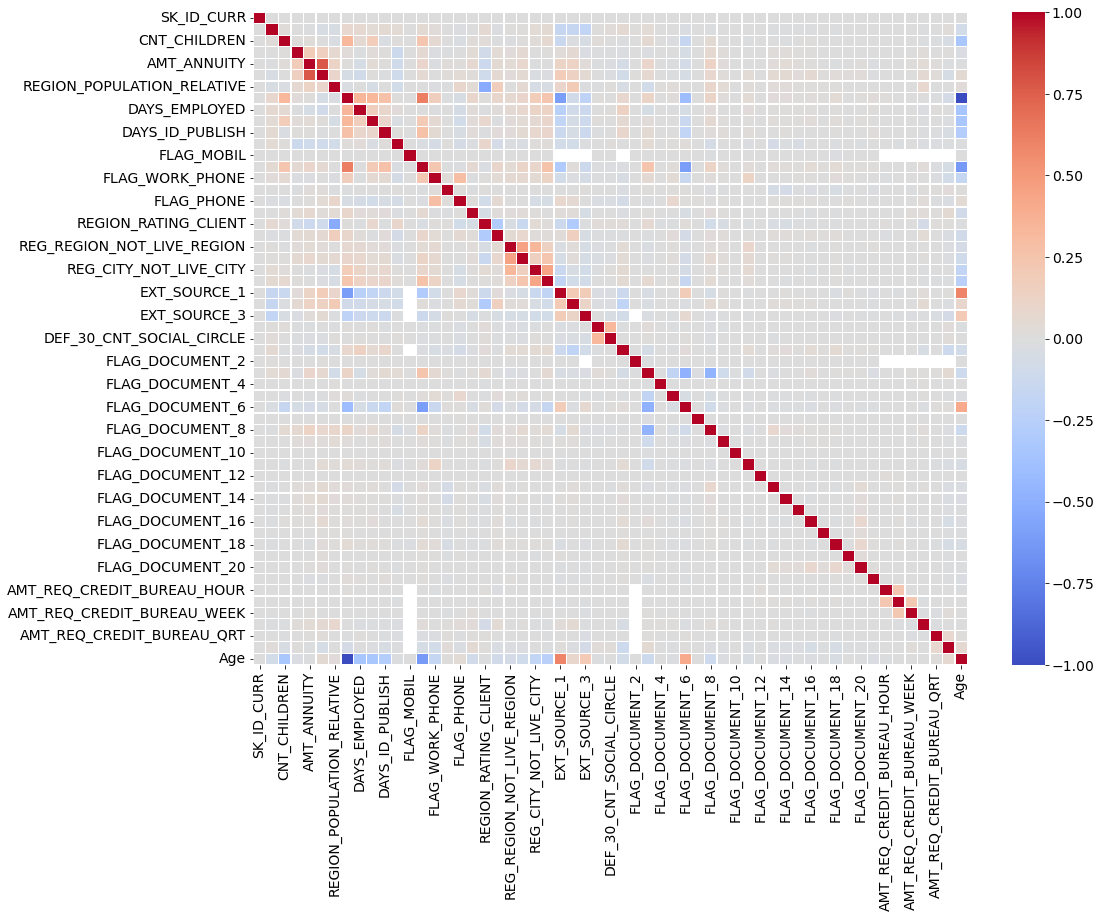

In [33]:
corr = new_data_train.corr()
pl.subplots(figsize=(16,12))
sn.heatmap(np.round(corr,2),linewidth=0.2,cmap='coolwarm')

### B-3) Nettoyer le dataframe

In [34]:
new_data_train.dtypes.value_counts()

int64      37
float64    20
object     16
dtype: int64

In [35]:
new_data_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0) ## cette fonction visualise le nbre des valeurs unique

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

<font color='darkblue'><font size="3"> 
Comme nous l'avons vu dans la section précédente, nous avons calculé le % de valeur manquante, maintenant nous voulons supprimer toutes les colonnes qui ont plus de 90% de valeur manquante.
</font></font>

In [36]:
table_object = pd.DataFrame(new_data_train.select_dtypes('object').isnull().sum()/(len(new_data_train))*100, columns=['percentage'])
liste_high_percentage = table_object[table_object['percentage']>=10].index

In [37]:
liste_high_percentage

Index(['OCCUPATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [38]:
#liste_high_percentage = ['OCCUPATION_TYPE','FONDKAPREMONT_MODE','HOUSETYPE_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE']
app_train = new_data_train.drop(columns=liste_high_percentage)

<font color='darkblue'><font size="3"> 
Afin d'avoir les mêmes colonnes dans le set train et test, nous allons supprimer toutes les colonnes qui ont été supprimées dans le set data_train.
</font></font>

In [39]:
liste_test = list(set(liste))+liste_high_percentage.tolist()
data_test.drop(columns=liste_test, inplace=True)

In [40]:
data_test.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,20560.5,450000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,17370.0,180000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,69777.0,630000.0,NaN,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,49018.5,1575000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,32067.0,625500.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


<font color='darkblue'><font size="3"> 
Nous avons créé une nouvelle colonne nommée "Age" et nous avons géré la valeur abberantes dans data_train, nous allons répéter la même procédure pour data_test
</font></font>

In [45]:
[i for i in app_train.keys().tolist() if not i in data_test.keys().tolist()]

['TARGET', 'Age']

In [46]:
data_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

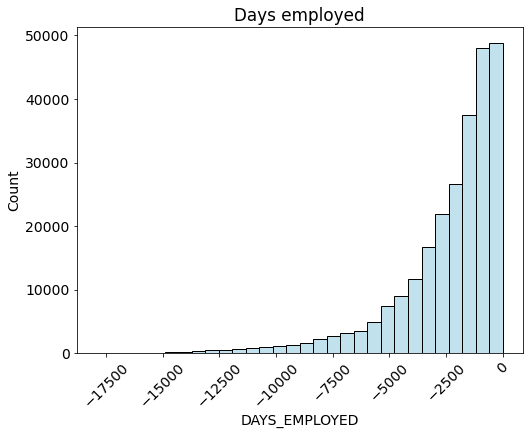

In [47]:
pl.figure(figsize=(8,6))
sn.histplot(x = 'DAYS_EMPLOYED', data = data_train, color = 'lightblue', bins = 30) 
#sns.barplot(x = result.index.get_level_values(0), y = result.values, hue = result.index.get_level_values(1), palette=palette)
pl.xticks(rotation=45)
pl.title('Days employed')
pl.show()

### B-4) Les variables catégorielles

<font color='darkblue'><font size="3"> 
Nous utiliserons le `LabelEncoder()` pour les variables catégorielles qui ont plus de deux valeurs différentes. Et `get_dummies()` pour celle qui ont deux ou moins.
</font></font>

In [49]:
label_encoder = preprocessing.LabelEncoder()
columns_count=0
for i in app_train.select_dtypes('object'):
    if len(list(app_train[i].unique())) > 2:
        
        label_encoder.fit(app_train[i].astype(str))
     
        app_train[i] = label_encoder.transform(app_train[i].astype(str))
        data_test[i] = label_encoder.transform(data_test[i].astype(str))
        columns_count += 1
            

In [50]:
app_train.select_dtypes('object')

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY
0,Cash loans,N,Y
1,Cash loans,N,N
2,Revolving loans,Y,Y
3,Cash loans,N,Y
4,Cash loans,N,Y
...,...,...,...
307506,Cash loans,N,N
307507,Cash loans,N,Y
307508,Cash loans,N,Y
307509,Cash loans,N,Y


In [51]:
app_train = pd.get_dummies(app_train)
data_test = pd.get_dummies(data_test)
app_train.drop(columns=['Age'],inplace=True)

In [52]:
app_train = app_train.fillna(0)
data_test = data_test.fillna(0)

### B-5) Classification

<font color='darkblue'><font size="3"> 
Maintenant, pour présenter notre modèle de baseline et pour tester sa précision, nous allons essayer le modèle le plus simple, la régression logistique avec data_train divisé en set Train/test.
</font></font>

In [54]:
X = app_train.drop(columns=['TARGET'])
y = app_train['TARGET']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=42)

In [56]:
scaler = StandardScaler()

scaler.fit(X_train)
x_train = scaler.transform(X_train)
x_test = scaler.transform(X_test)

In [57]:
LR = LogisticRegression(penalty='l2').fit(x_train, y_train)
LR.score(x_train, y_train)

0.9191312604874411

### B-6) Les scores metrics du baseline

In [58]:
y_pred = LR.predict(x_test)

In [59]:
print('le score du ROC-AUC:',metrics.roc_auc_score(y_test, y_pred))
print('le score d\'accuracy:',metrics.accuracy_score(y_test, y_pred))
print('le score de F1:', metrics.f1_score(y_test, y_pred))

print('le score de precision:',metrics.average_precision_score(y_test, y_pred))
print('le score du recall:', metrics.recall_score(y_test, y_pred))
print('Matrix confusion',metrics.confusion_matrix(y_test, y_pred))

le score du ROC-AUC: 0.5005329241935536
le score d'accuracy: 0.9193657483285205
le score de F1: 0.0025744167337087695
le score de precision: 0.08085686249616025
le score du recall: 0.0012921983524471006
Matrix confusion [[70671    16]
 [ 6183     8]]


## C) DataFrame "bureau/bureau_balance"

<font color='darkblue'><font size="3"> 
Comme nous avons déjà présenté notre modèle de baseline, il est maintenant temps de commencer à ajouter certaines caractéristiques existant dans d'autres dataframe à notre train/test set afin d'améliorer nos résultats de metrics. 
</font></font>

In [62]:
data_bureau = pd.read_csv("bureau.csv")

In [63]:
data_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


<font color='darkblue'><font size="3">
data_bureau contient plusieurs lignes pour chaque client. Par la suite, pour regrouper ces informations, nous allons compter le nombre de prêts précédents demandés par le même client, et nous allons compter la "moyenne" et la "somme" des colonnes numériques de data_bureau. Et ensuite nous fusionnons ces informations dans le data_train.
</font></font>

### C-1) Compter les prêts précédentes (dataframe: bureau)

In [64]:
previous_loan = data_bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan.sort_values(by=['previous_loan_counts'],ascending=False).head()

,SK_ID_CURR,previous_loan_counts
17942,120860,116
59911,169704,94
187259,318065,78
130327,251643,61
279405,425396,60


In [65]:
train = app_train.merge(previous_loan, on = 'SK_ID_CURR', how = 'left')

### C-2) Les stats des prêts précédentes (dataframe: bureau)

In [66]:
# Group by the client id, calculate aggregation statistics
bureau = data_bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg([ 'mean', 'sum']).reset_index()
bureau.columns = ["_".join(x) for x in bureau.columns.ravel()]
bureau.head()

,SK_ID_CURR_,DAYS_CREDIT_mean,DAYS_CREDIT_sum,CREDIT_DAY_OVERDUE_mean,CREDIT_DAY_OVERDUE_sum,DAYS_CREDIT_ENDDATE_mean,DAYS_CREDIT_ENDDATE_sum,DAYS_ENDDATE_FACT_mean,DAYS_ENDDATE_FACT_sum,AMT_CREDIT_MAX_OVERDUE_mean,...,AMT_CREDIT_SUM_DEBT_mean,AMT_CREDIT_SUM_DEBT_sum,AMT_CREDIT_SUM_LIMIT_mean,AMT_CREDIT_SUM_LIMIT_sum,AMT_CREDIT_SUM_OVERDUE_mean,AMT_CREDIT_SUM_OVERDUE_sum,DAYS_CREDIT_UPDATE_mean,DAYS_CREDIT_UPDATE_sum,AMT_ANNUITY_mean,AMT_ANNUITY_sum
0,100001,-735.000000,-5145,0.0,0,82.428571,577.0,-825.500000,-3302.0,NaN,...,85240.928571,596686.5,0.00000,0.000,0.0,0.0,-93.142857,-652,3545.357143,24817.5
1,100002,-874.000000,-6992,0.0,0,-349.000000,-2094.0,-697.500000,-4185.0,1681.029,...,49156.200000,245781.0,7997.14125,31988.565,0.0,0.0,-499.875000,-3999,0.000000,0.0
2,100003,-1400.750000,-5603,0.0,0,-544.500000,-2178.0,-1097.333333,-3292.0,0.000,...,0.000000,0.0,202500.00000,810000.000,0.0,0.0,-816.000000,-3264,NaN,0.0
3,100004,-867.000000,-1734,0.0,0,-488.500000,-977.0,-532.500000,-1065.0,0.000,...,0.000000,0.0,0.00000,0.000,0.0,0.0,-532.000000,-1064,NaN,0.0
4,100005,-190.666667,-572,0.0,0,439.333333,1318.0,-123.000000,-123.0,0.000,...,189469.500000,568408.5,0.00000,0.000,0.0,0.0,-54.333333,-163,1420.500000,4261.5


In [67]:
bureau.rename(columns={'SK_ID_CURR_':'SK_ID_CURR'},inplace= True)

In [68]:
train = train.merge(bureau, on = 'SK_ID_CURR', how = 'left')
train.head()

,SK_ID_CURR,TARGET,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,AMT_CREDIT_SUM_DEBT_mean,AMT_CREDIT_SUM_DEBT_sum,AMT_CREDIT_SUM_LIMIT_mean,AMT_CREDIT_SUM_LIMIT_sum,AMT_CREDIT_SUM_OVERDUE_mean,AMT_CREDIT_SUM_OVERDUE_sum,DAYS_CREDIT_UPDATE_mean,DAYS_CREDIT_UPDATE_sum,AMT_ANNUITY_mean,AMT_ANNUITY_sum
0,100002,1,1,0,202500.0,24700.5,351000.0,6,7,4,...,49156.2,245781.0,7997.14125,31988.565,0.0,0.0,-499.875,-3999.0,0.0,0.0
1,100003,0,0,0,270000.0,35698.5,1129500.0,1,4,1,...,0.0,0.0,202500.00000,810000.000,0.0,0.0,-816.000,-3264.0,NaN,0.0
2,100004,0,1,0,67500.0,6750.0,135000.0,6,7,4,...,0.0,0.0,0.00000,0.000,0.0,0.0,-532.000,-1064.0,NaN,0.0
3,100006,0,0,0,135000.0,29686.5,297000.0,6,7,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,1,0,121500.0,21865.5,513000.0,6,7,4,...,0.0,0.0,0.00000,0.000,0.0,0.0,-783.000,-783.0,NaN,0.0


In [69]:
new_bureau = data_bureau.select_dtypes('object')
new_bureau['SK_ID_CURR'] = data_bureau['SK_ID_CURR']

<ipython-input-69-91e30ac468b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_bureau['SK_ID_CURR'] = data_bureau['SK_ID_CURR']


In [70]:
data_bureau.select_dtypes('object').columns

Index(['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'], dtype='object')

In [71]:
new_bureau.head()

,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE,SK_ID_CURR
0,Closed,currency 1,Consumer credit,215354
1,Active,currency 1,Credit card,215354
2,Active,currency 1,Consumer credit,215354
3,Active,currency 1,Credit card,215354
4,Active,currency 1,Consumer credit,215354


In [72]:
new_bureau_dum = pd.get_dummies(new_bureau.set_index('SK_ID_CURR')).sum(level=0)
#new_bureau.melt('SK_ID_CURR').assign(new=0).pivot('SK_ID_CURR','value','new').fillna(0)

In [73]:
train = train.merge(new_bureau_dum, on = 'SK_ID_CURR', how = 'left')

In [74]:
train = train.fillna(0)

### C-3) Les stats des prêts précédentes (dataframe: bureau_balance)

In [75]:
data_bureau_balance = pd.read_csv("bureau_balance.csv")

In [76]:
data_bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


<font color='darkblue'><font size="3">
nous répétons le même travail de data_bureau sur data_bureau_balance
</font></font>

In [77]:
data_bureau_balance_new = data_bureau_balance.groupby('SK_ID_BUREAU', as_index = False).agg([ 'mean', 'sum']).reset_index()
data_bureau_balance_new.columns = ["_".join(x) for x in data_bureau_balance_new.columns.ravel()]
data_bureau_balance_new.head()

,SK_ID_BUREAU_,MONTHS_BALANCE_mean,MONTHS_BALANCE_sum
0,5001709,-48.0,-4656
1,5001710,-41.0,-3403
2,5001711,-1.5,-6
3,5001712,-9.0,-171
4,5001713,-10.5,-231


In [78]:
data_bureau_balance_new.rename(columns={'SK_ID_BUREAU_':'SK_ID_BUREAU'},inplace= True)

In [79]:
#data_bureau_balance.drop(columns=['MONTHS_BALANCE'])
data_bureau_balance_dum = pd.get_dummies(data_bureau_balance.drop(columns=['MONTHS_BALANCE']).set_index('SK_ID_BUREAU')).sum(level=0)

In [80]:
bureau_by_loan = data_bureau_balance_new.merge(data_bureau_balance_dum, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

bureau_by_loan = bureau_by_loan.merge(data_bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

In [81]:
bureau_by_loan

,SK_ID_BUREAU,MONTHS_BALANCE_mean,MONTHS_BALANCE_sum,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,SK_ID_CURR
0,5001709,-48.0,-4656,0,0,0,0,0,0,86,11,NaN
1,5001710,-41.0,-3403,5,0,0,0,0,0,48,30,162368.0
2,5001711,-1.5,-6,3,0,0,0,0,0,0,1,162368.0
3,5001712,-9.0,-171,10,0,0,0,0,0,9,0,162368.0
4,5001713,-10.5,-231,0,0,0,0,0,0,0,22,150635.0
...,...,...,...,...,...,...,...,...,...,...,...,...
817390,6842884,-23.5,-1128,9,0,0,0,0,0,20,19,387020.0
817391,6842885,-11.5,-276,12,0,0,0,0,12,0,0,387020.0
817392,6842886,-16.0,-528,8,0,0,0,0,0,25,0,387020.0
817393,6842887,-18.0,-666,6,0,0,0,0,0,31,0,387020.0


### C-4) Compter les prêts précédentes (dataframe: bureau_balance)

In [82]:
bureau_loan_client = bureau_by_loan.drop(columns=["SK_ID_BUREAU"])
bureau_client = bureau_loan_client.groupby('SK_ID_CURR', as_index = False).agg([ 'mean', 'sum']).reset_index()
bureau_client.columns = ["_".join(x) for x in bureau_client.columns.ravel()]

In [83]:
bureau_client.rename(columns={'SK_ID_CURR_':'SK_ID_CURR'},inplace= True)

In [84]:
bureau_client.head()

,SK_ID_CURR,MONTHS_BALANCE_mean_mean,MONTHS_BALANCE_mean_sum,MONTHS_BALANCE_sum_mean,MONTHS_BALANCE_sum_sum,STATUS_0_mean,STATUS_0_sum,STATUS_1_mean,STATUS_1_sum,STATUS_2_mean,...,STATUS_3_mean,STATUS_3_sum,STATUS_4_mean,STATUS_4_sum,STATUS_5_mean,STATUS_5_sum,STATUS_C_mean,STATUS_C_sum,STATUS_X_mean,STATUS_X_sum
0,100001.0,-11.785714,-82.5,-400.000000,-2800,4.428571,31.0,0.142857,1,0.0,...,0.0,0,0.0,0,0.0,0.0,15.714286,110.0,4.285714,30.0
1,100002.0,-21.875000,-175.0,-337.625000,-2701,5.625000,45.0,3.375000,27,0.0,...,0.0,0,0.0,0,0.0,0.0,2.875000,23.0,1.875000,15.0
2,100005.0,-3.000000,-9.0,-30.333333,-91,4.666667,14.0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0.0,1.666667,5.0,0.666667,2.0
3,100010.0,-46.000000,-92.0,-1656.000000,-3312,10.000000,20.0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0.0,26.000000,52.0,0.000000,0.0
4,100013.0,-28.250000,-113.0,-1689.000000,-6756,19.750000,79.0,1.750000,7,0.0,...,0.0,0,0.0,0,0.0,0.0,25.750000,103.0,10.250000,41.0


In [85]:
train = train.merge(bureau_client, on = 'SK_ID_CURR', how = 'left')

In [89]:
pd.DataFrame(np.round(100*train.isnull().sum()/len(train)),columns=['percentage of Nan']).sort_values(by='percentage of Nan', ascending=False)

,percentage of Nan
STATUS_X_sum,70.0
STATUS_2_sum,70.0
MONTHS_BALANCE_mean_mean,70.0
MONTHS_BALANCE_mean_sum,70.0
MONTHS_BALANCE_sum_sum,70.0
...,...
EXT_SOURCE_3,0.0
EXT_SOURCE_2,0.0
EXT_SOURCE_1,0.0
ORGANIZATION_TYPE,0.0


In [110]:
train = train.fillna(0)

In [90]:
train.to_csv('new_train.csv',index=False)  

### C-5) Merge les nouveau dataframes avec data_test

In [86]:
data_test = data_test.merge(previous_loan, on = 'SK_ID_CURR')

# Merge with the stats of bureau
data_test = data_test.merge(bureau, on = 'SK_ID_CURR')
data_test = data_test.merge(new_bureau_dum, on = 'SK_ID_CURR')

# Merge with the value counts of bureau balance
data_test = data_test.merge(bureau_client, on = 'SK_ID_CURR')

In [87]:
pd.DataFrame(np.round(100*data_test.isnull().sum()/len(data_test)),columns=['percentage of Nan']).sort_values(by='percentage of Nan', ascending=False)

,percentage of Nan
AMT_CREDIT_MAX_OVERDUE_mean,31.0
DAYS_ENDDATE_FACT_mean,11.0
AMT_ANNUITY_mean,10.0
AMT_CREDIT_SUM_LIMIT_mean,10.0
AMT_CREDIT_SUM_DEBT_mean,2.0
...,...
FLAG_DOCUMENT_5,0.0
FLAG_DOCUMENT_4,0.0
FLAG_DOCUMENT_3,0.0
FLAG_DOCUMENT_2,0.0


In [88]:
print('Shape of Training Data: ', train.shape)
print('Shape of Testing Data: ', data_test.shape)

Shape of Training Data:  (307511, 138)
Shape of Testing Data:  (42311, 137)


In [89]:
[i for i in train.keys().tolist() if not i in data_test.keys().tolist()]

['TARGET']

In [91]:
data_test.to_csv('new_test.csv',index=False)  

<font color='darkblue'><font size="3">
Le notebook jupyter suivant est P7_adding_more_features.ipynb
</font></font>